# Working with a curvilinear grid

We use polar coordinates ($r,\theta$) with the singularity at $r=0$.

In [1]:
using Makie, CairoMakie
using DIVAnd

## Create polar grid

<div class="alert alert-block alert-info">
ℹ️ We take out the last theta to not close, that will be done by the parameter `moddim`.
</div>

In [2]:
ri,ti = ndgrid(range(0.001,stop=1,length=100),range(0,stop=2pi,length=210));
ri=ri[:,1:end-1]
ti=ti[:,1:end-1]
mask = trues(size(ri));

## Create plots
Using synthetic observations

In [3]:
xi=ri.*cos.(ti)
yi=ri.*sin.(ti);
fi=sin.(4*xi) .* cos.(4*yi);

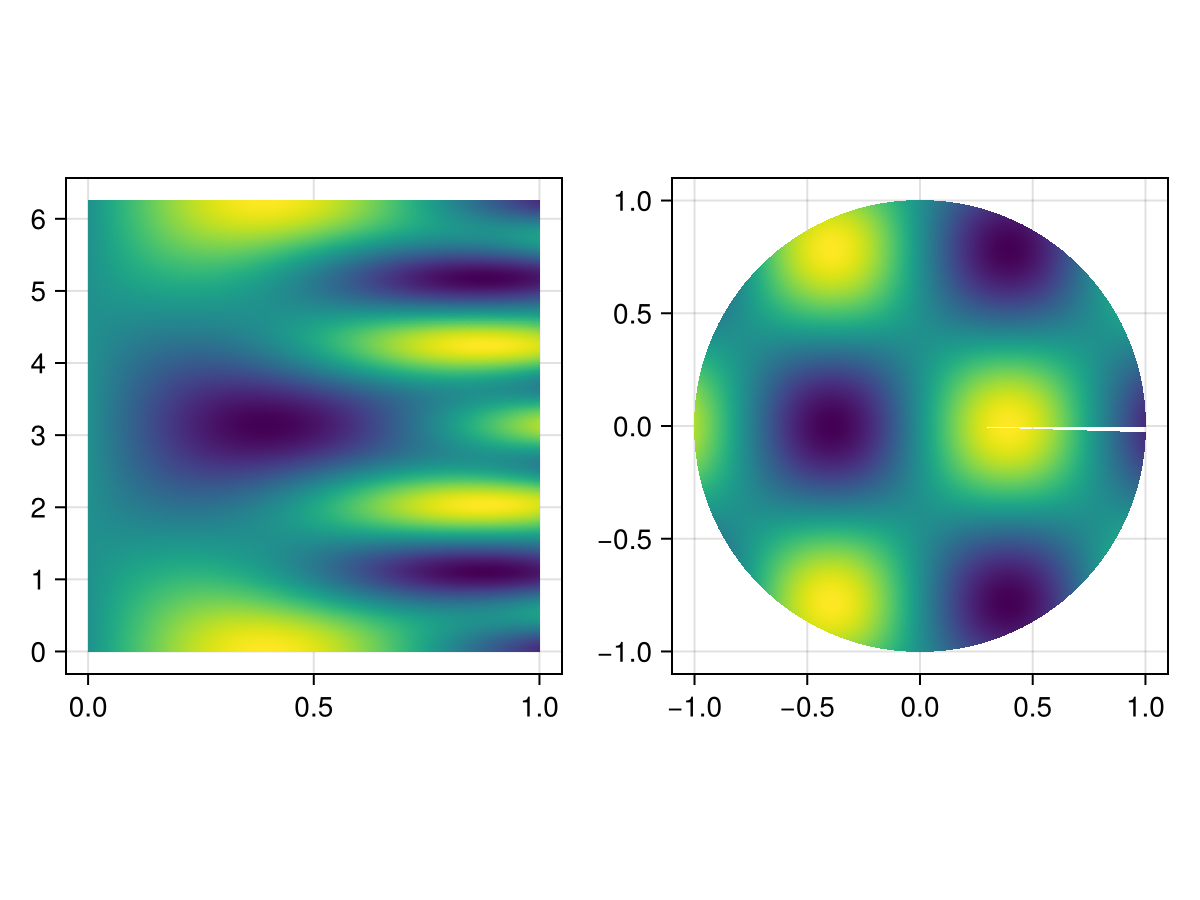

CairoMakie.Screen{IMAGE}


In [4]:
fig = Figure()
ax1 = Axis(fig[1,1], aspect=1)
surface!(ax1, ri, ti, fi, shading=NoShading, interpolate=false)
ax2 = Axis(fig[1,2], aspect=1)
surface!(ax2, xi, yi, fi, shading=NoShading, interpolate=false)
display(fig)

Naive interpolation; note how the scale of the patch changes depending on the position

In [5]:
# naive analysis as if polar coordinates where cartesian
pmc = ones(size(ri)) / (ri[2,1]-ri[1,1]);
pnc = ones(size(ti)) / (ti[1,2]-ti[1,1]);
r=[0.25,0.5,0.75]
t=[pi,0.0,pi]
f=[1.0,-1.0,-1.0]
fi,s = DIVAndrun(mask,(pmc,pnc),(ri,ti),(r,t),f,(0.1,pi/7),1.0);

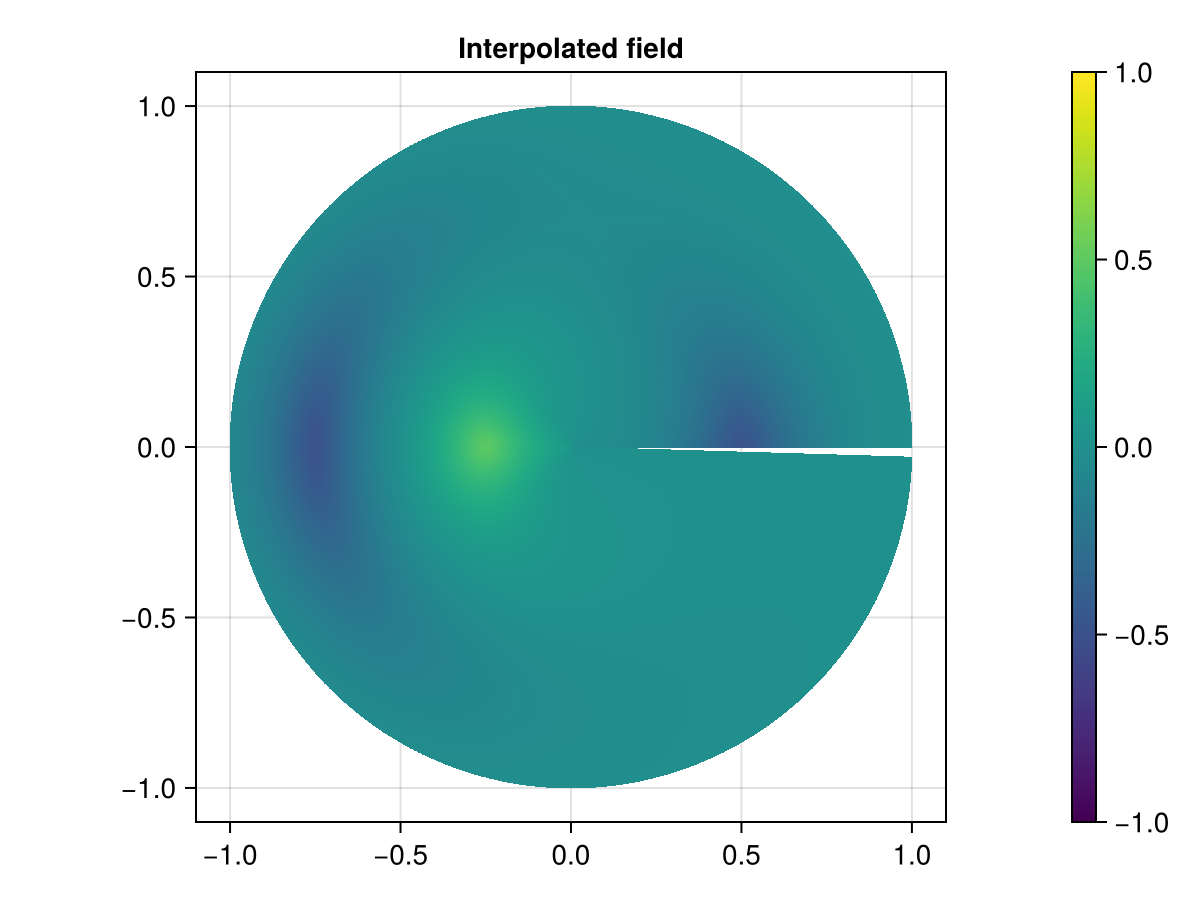

CairoMakie.Screen{IMAGE}


In [6]:
fig = Figure()
ax = Axis(fig[1,1], aspect=1, title="Interpolated field")
su = surface!(ax, xi, yi, fi, shading=NoShading, interpolate=false, colorrange=[-1,1])
Colorbar(fig[1, 2], su)
display(fig)

Now using the real metrics. Here done by hand; for lon,lat coordinates on Earth, there is a predefined function DIVAnd_metric you can use directly

## Metrics

In [7]:
function mydistance(r1,t1,r2,t2)
   
    x1=r1*cos(t1)
    y1=r1*sin(t1)
    x2=r2*cos(t2)
    y2=r2*sin(t2)
    
    return sqrt((x2-x1)^2+(y2-y1)^2)
    
end

function DIVAnd_mymetric(rad::Array{T,2}, t::Array{T,2}) where {T}
    sz = size(rad)
    pm = zeros(sz)
    pn = zeros(sz)


    for i = 1:sz[1]
        i0 = max(i - 1, 1)
        i1 = min(i + 1, sz[1])

        for j = 1:sz[2]
            j0 = max(j - 1, 1)
            j1 = min(j + 1, sz[2])

            dx = mydistance(rad[i0, j], t[i0, j], rad[i1, j], t[i1, j]) / (i1 - i0)
            dy = mydistance(rad[i, j0], t[i, j0], rad[i, j1], t[i, j1]) / (j1 - j0)

            dx = real(dx)
            dy = real(dy)

            pm[i, j] = 1 / dx
            pn[i, j] = 1 / dy
        end
    end

    return pm, pn
end

DIVAnd_mymetric (generic function with 1 method)

## Analysis
### Simple analysis

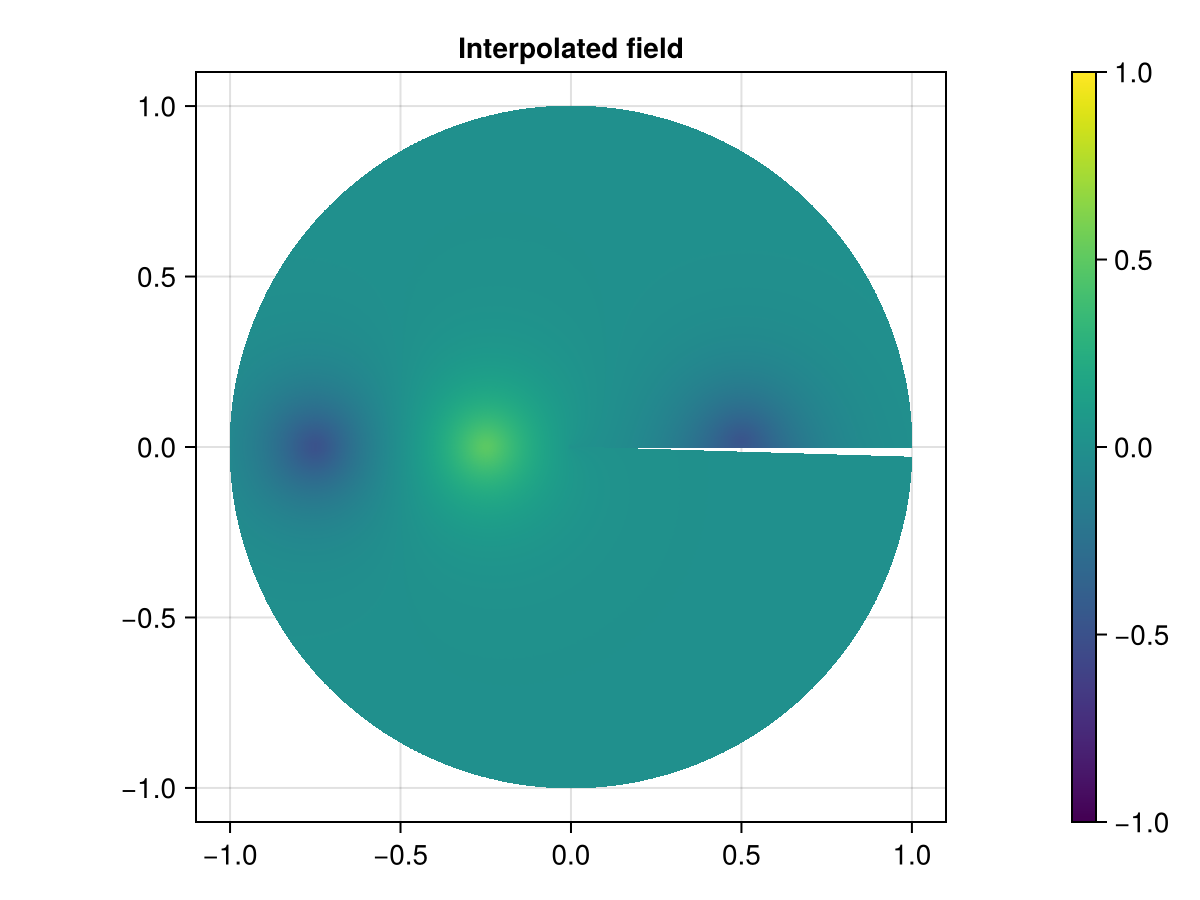

CairoMakie.Screen{IMAGE}


In [8]:
pm,pn=DIVAnd_mymetric(ri,ti)

r=[0.25,0.5,0.75]
t=[pi,0.0,pi]
f=[1.0,-1.0,-1.0]
fi,s = DIVAndrun(mask,(pm,pn),(ri,ti),(r,t),f,(0.1,0.1),1.0);

fig = Figure()
ax = Axis(fig[1,1], aspect=1, title="Interpolated field")
su = surface!(ax, xi, yi, fi, shading=NoShading, interpolate=false, colorrange=[-1,1])
Colorbar(fig[1, 2], su)
display(fig)

### With periodicity
Now adding periodicy. Note how the analyses wraps around       
(the gap is just a plotting artefact due to pcolor not aware of the periodicity closing

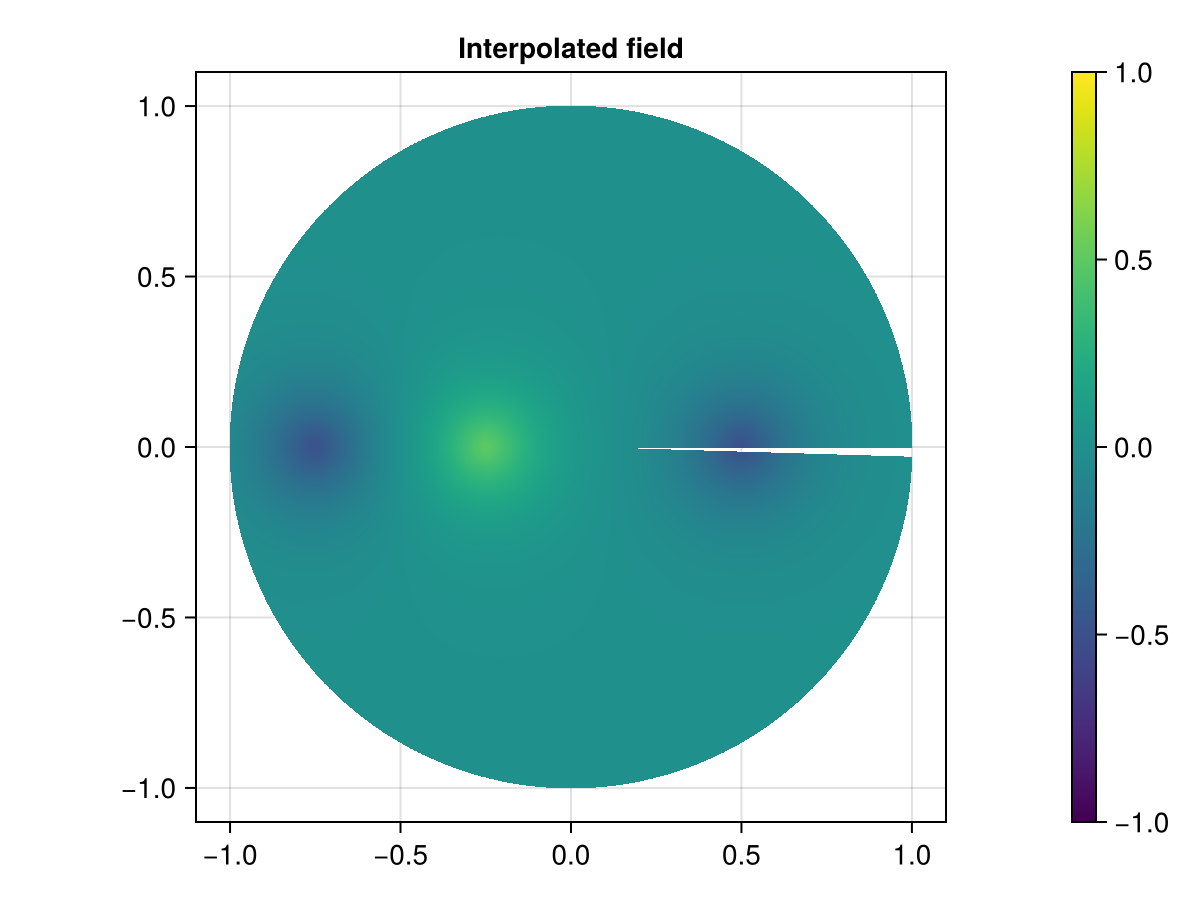

CairoMakie.Screen{IMAGE}


In [9]:
r=[0.25,0.5,0.75]
t=[pi,0.0,pi]
f=[1.0,-1.0,-1.0]
fi,s = DIVAndrun(mask,(pm,pn),(ri,ti),(r,t),f,(0.1,0.1),1.0,moddim=[0,1]);

fig = Figure()
ax = Axis(fig[1,1], aspect=1, title="Interpolated field")
su = surface!(ax, xi, yi, fi, shading=NoShading, interpolate=false, colorrange=[-1,1])
Colorbar(fig[1, 2], su)
display(fig)

Now look at the real data for correct and naive analysis. Sample in real domain of course!

In [19]:
x=-1 .+ 2*rand(100)
y=-1 .+ 2*rand(100)
r=sqrt.(x.^2 .+ y.^2)
t=atan.(y,x) .+ pi # to map to 0 to 2 pi
f=sin.(4*x) .* cos.(4*y);

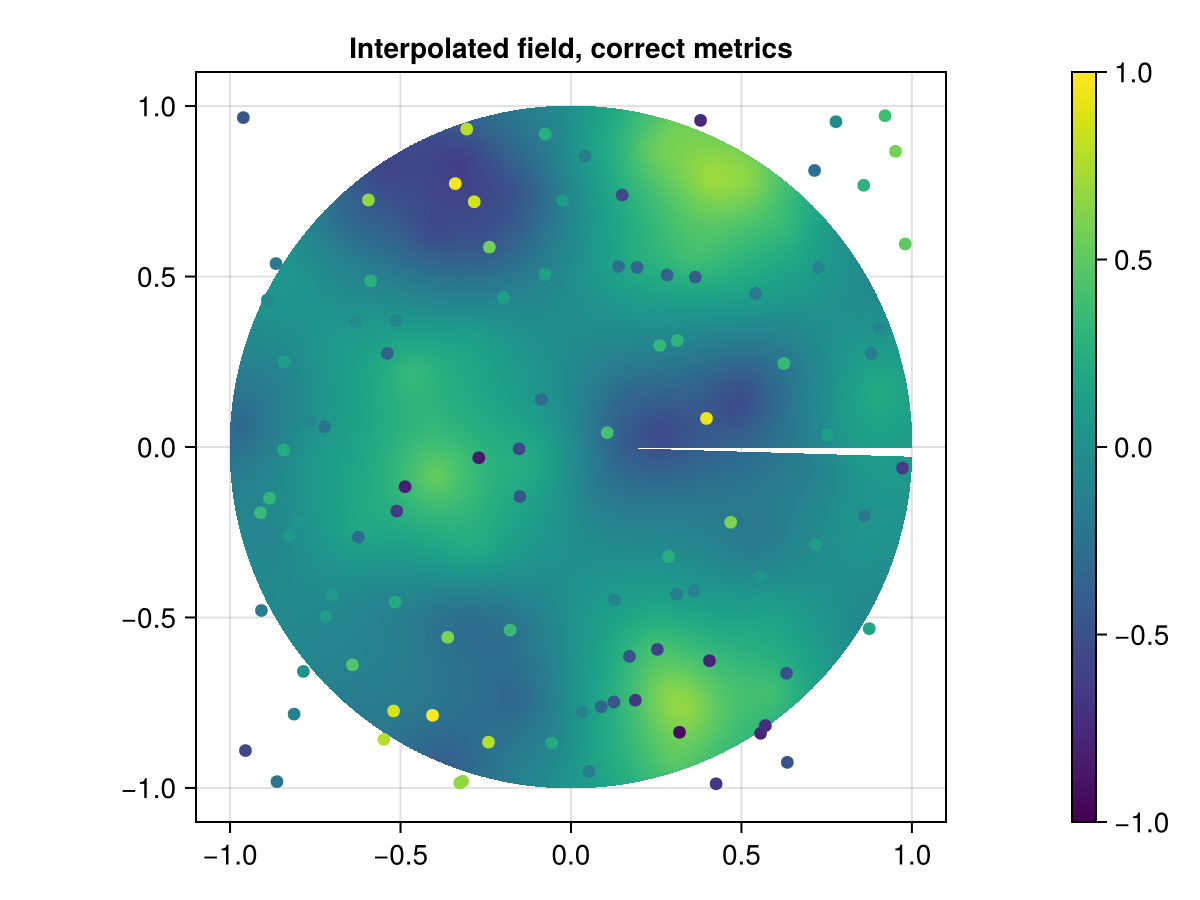

CairoMakie.Screen{IMAGE}


In [26]:
fi,s = DIVAndrun(mask,(pm,pn),(ri,ti),(r,t),f,(0.1,0.1),1.0,moddim=[0,1]);

fig = Figure()
ax = Axis(fig[1,1], aspect=1, title="Interpolated field, correct metrics")
su = surface!(ax, xi, yi, fi, shading=NoShading, interpolate=false, colorrange=[-1,1])
scatter!(ax, x, y, color=f, colorrange=[-1,1])
Colorbar(fig[1, 2], su)
display(fig)

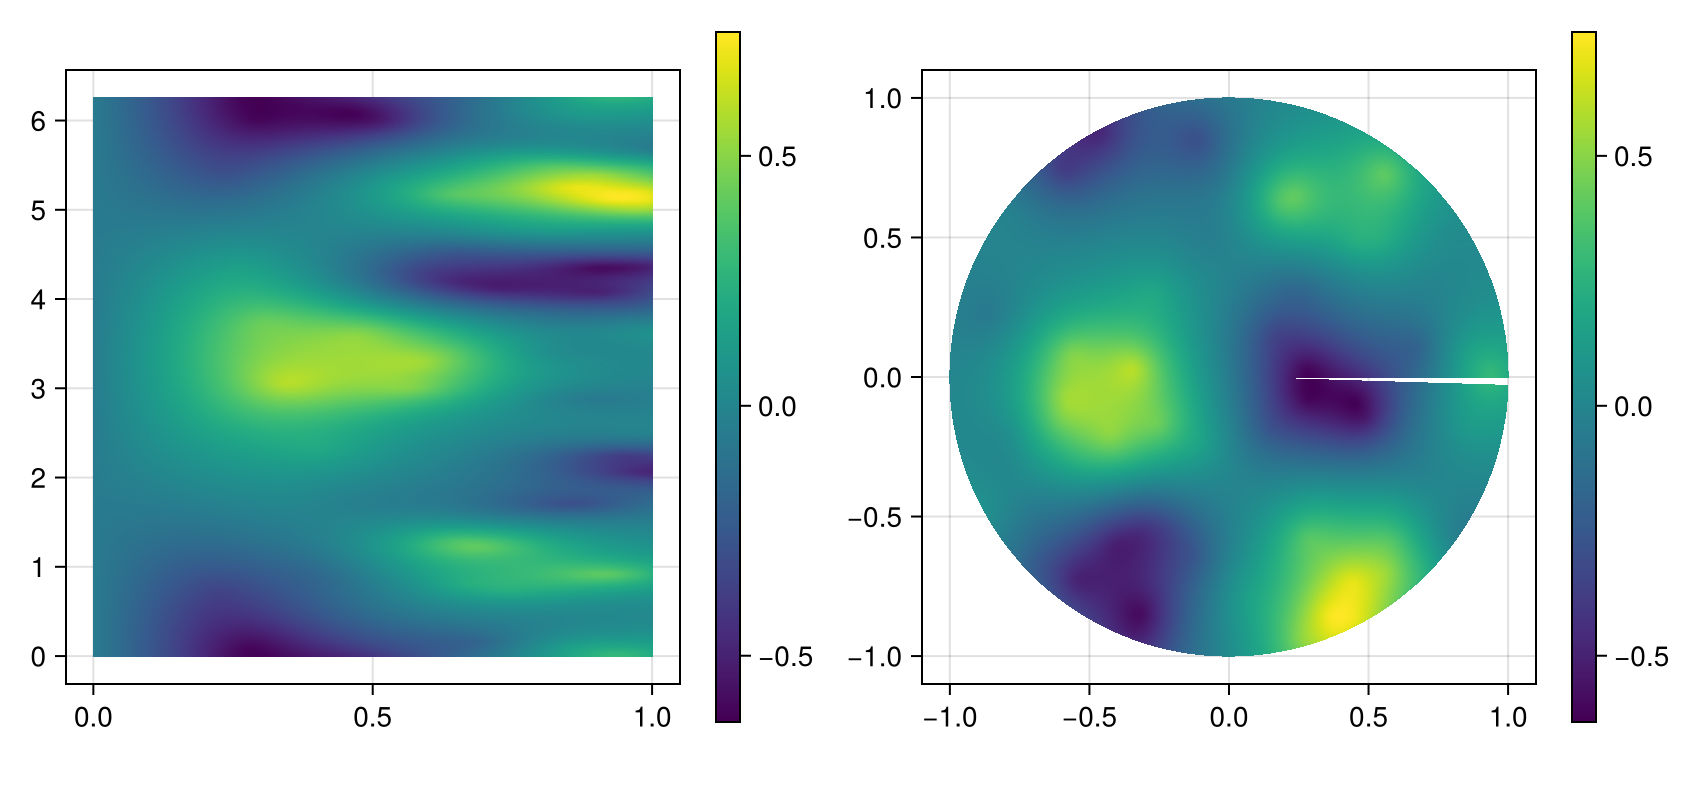

CairoMakie.Screen{IMAGE}


In [12]:
fig = Figure(size = (850, 400))
ax1 = Axis(fig[1,1], aspect=1)
su1 = surface!(ax1, ri, ti, fi, shading=NoShading, interpolate=false)
Colorbar(fig[1, 2], su1)
ax2 = Axis(fig[1,3], aspect=1)
su2 = surface!(ax2, xi, yi, fi, shading=NoShading, interpolate=false)
Colorbar(fig[1, 4], su2)
display(fig)

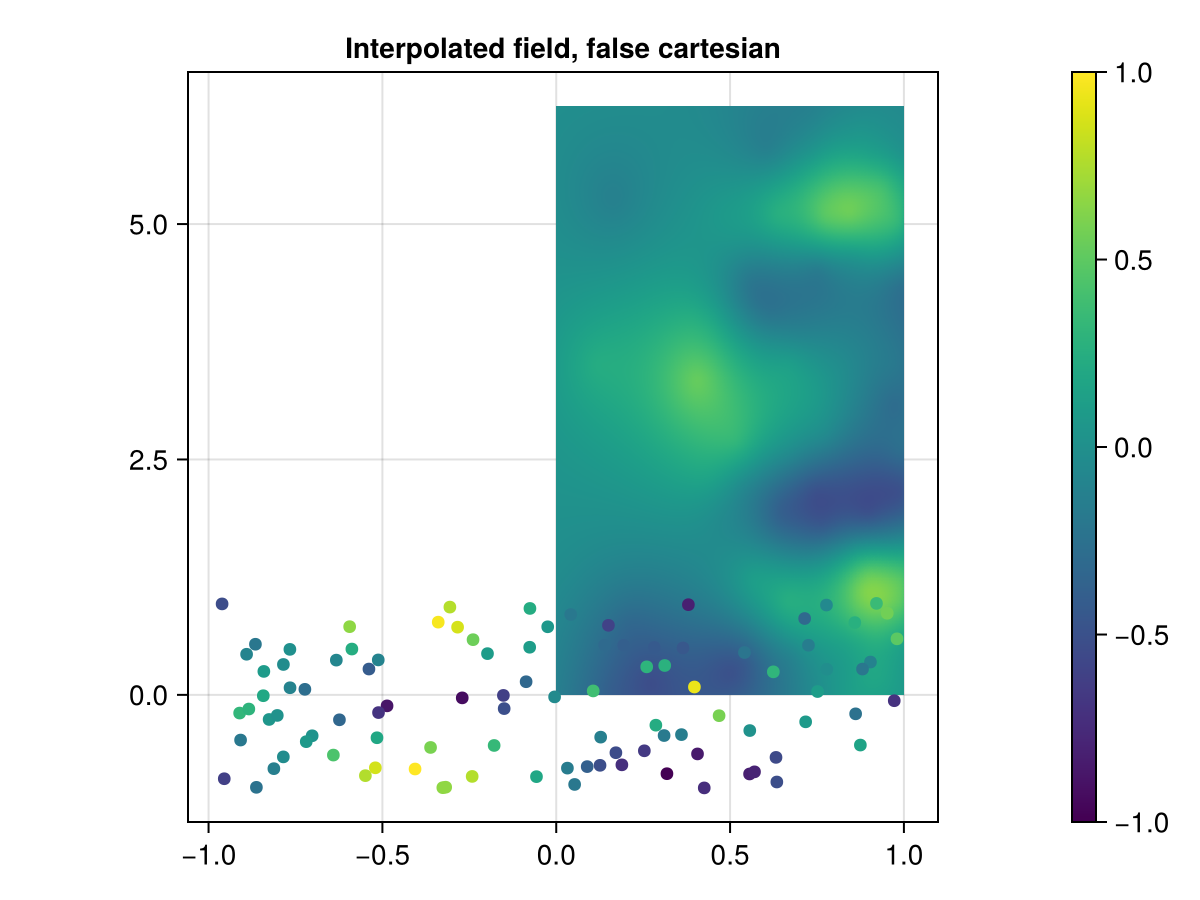

CairoMakie.Screen{IMAGE}


In [41]:
fi,s = DIVAndrun(mask,(pmc,pnc),(ri,ti),(r,t),f,(0.1,pi/7),1.0);
fig = Figure()
ax = Axis(fig[1,1], aspect=1, title="Interpolated field false cartesian")
su = surface!(ax, xi, yi, fi, shading=NoShading, interpolate=false, colorrange=[-1,1])
scatter!(ax, x, y)
Colorbar(fig[1, 2], su)
display(fig)

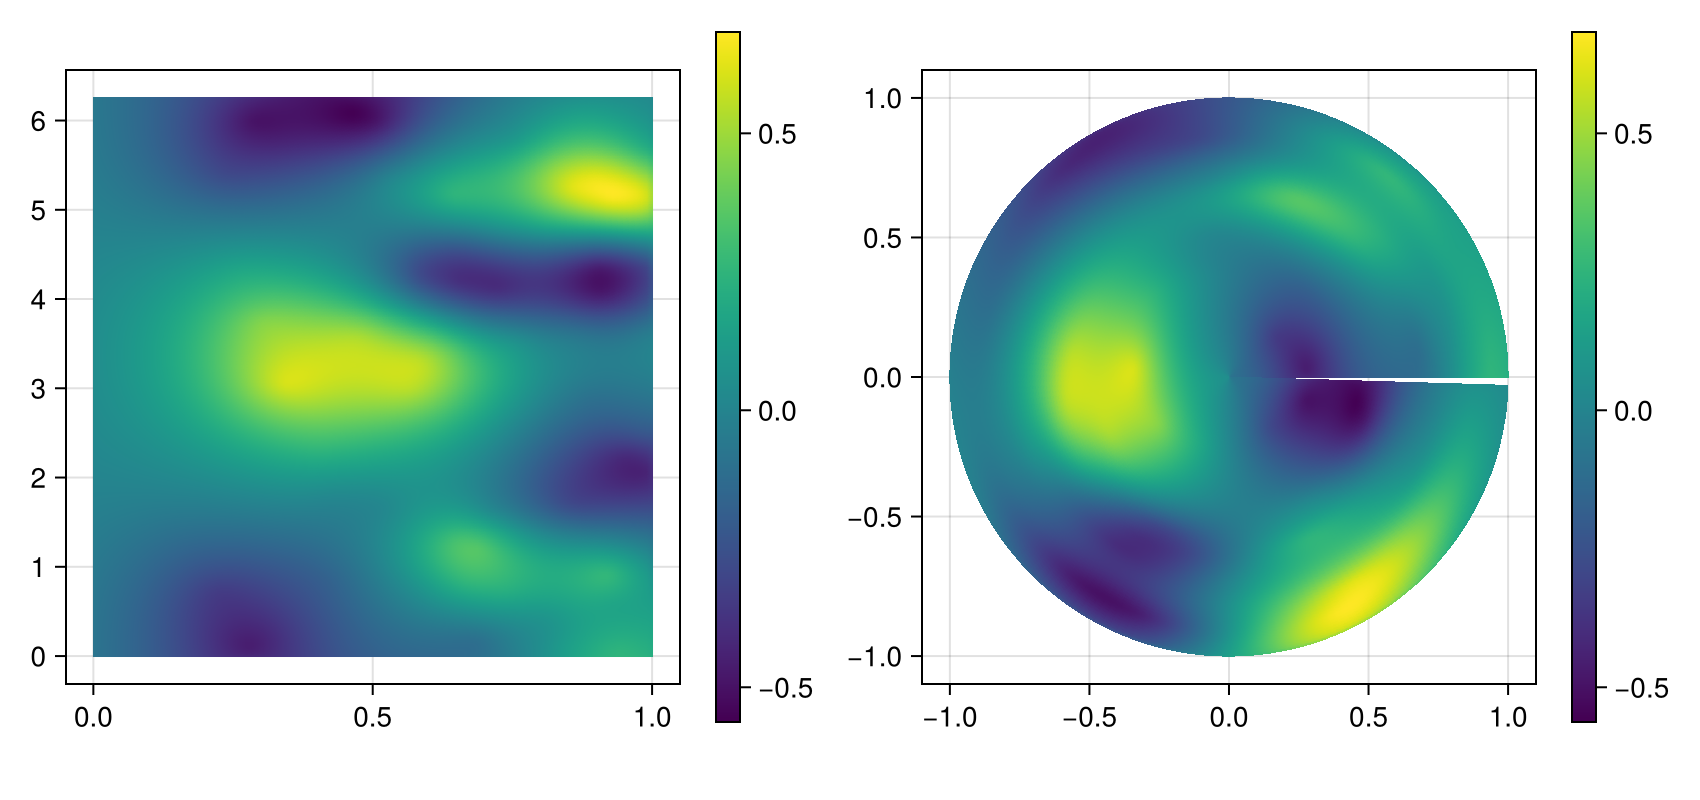

CairoMakie.Screen{IMAGE}


In [14]:
fig = Figure(size = (850, 400))
ax1 = Axis(fig[1,1], aspect=1)
su1 = surface!(ax1, ri, ti, fi, shading=NoShading, interpolate=false)
Colorbar(fig[1, 2], su1)
ax2 = Axis(fig[1,3], aspect=1)
su2 = surface!(ax2, xi, yi, fi, shading=NoShading, interpolate=false)
Colorbar(fig[1, 4], su2)
display(fig)

In [35]:
xx = range(0, 10)
yy = range(1, 20)
xxx, yyy = ndgrid(xx, yy)
fff = 3. .* cos.(xxx) .* sin.(2*yyy)

11×20 Matrix{Float64}:
  2.72789   -2.27041   -0.838246  …  -2.97534    0.889106   2.23534
  1.47389   -1.22671   -0.452907     -1.60758    0.480386   1.20776
 -1.1352     0.944823   0.348834      1.23818   -0.369999  -0.930229
 -2.70059    2.24769    0.829858      2.94556   -0.880208  -2.21297
 -1.78307    1.48404    0.547914      1.94481   -0.581158  -1.46112
  0.7738    -0.644029  -0.237779  …  -0.84399    0.252206   0.634081
  2.61924   -2.17998   -0.804859     -2.85683    0.853693   2.14631
  2.05656   -1.71167   -0.631956     -2.24311    0.670299   1.68523
 -0.396908   0.330344   0.121965      0.432912  -0.129365  -0.325242
 -2.48547    2.06864    0.763752      2.71092   -0.810091  -2.03669
 -2.2889     1.90503    0.703349  …   2.49652   -0.746023  -1.87561

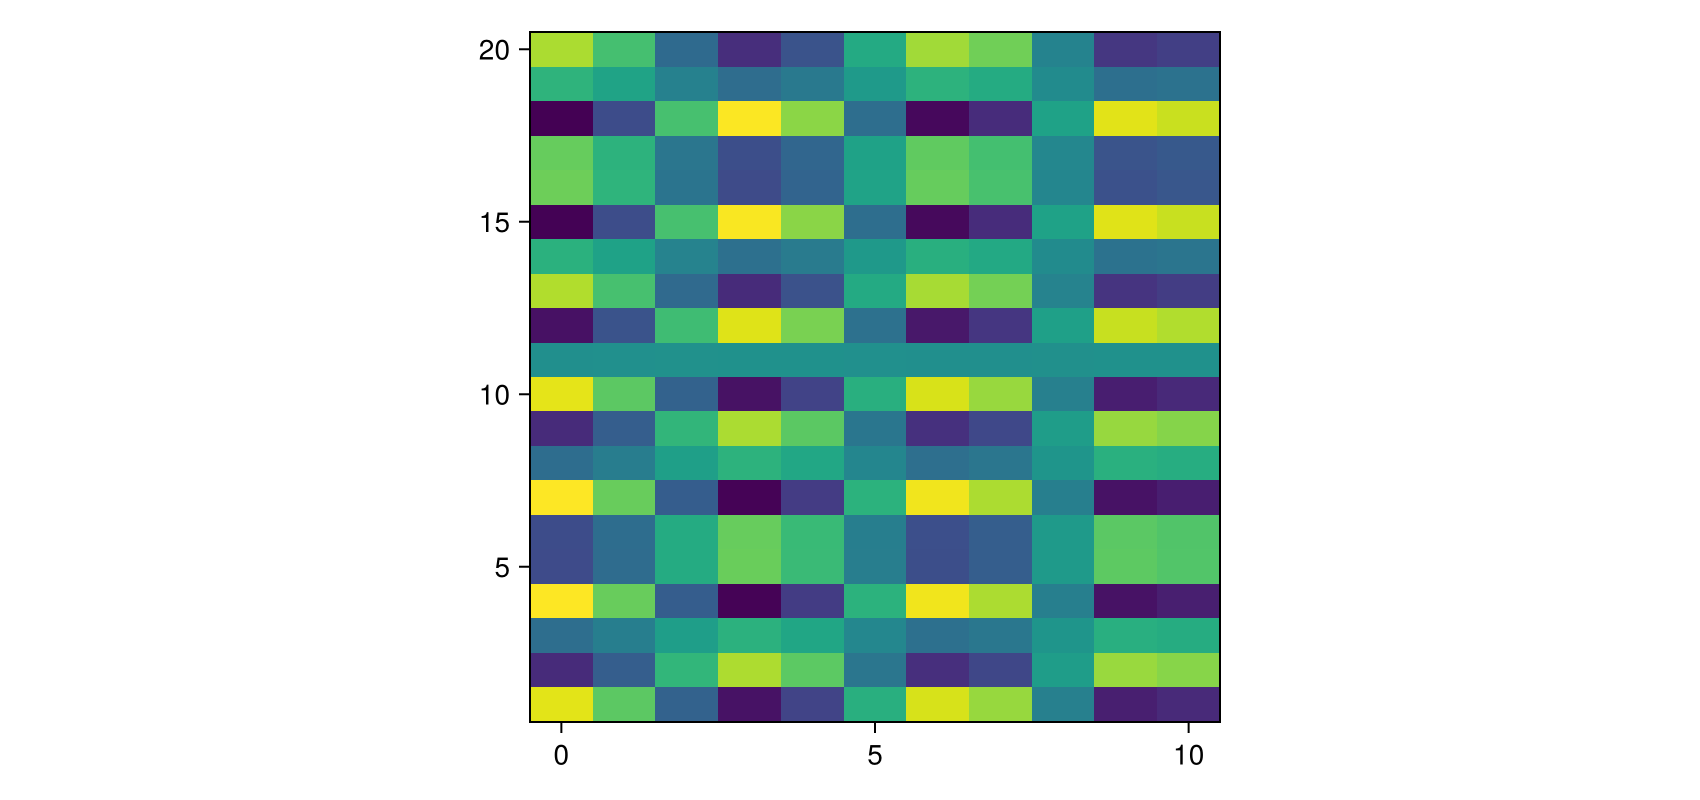

CairoMakie.Screen{IMAGE}


In [37]:
fig = Figure(size = (850, 400))
ax1 = Axis(fig[1,1], aspect=1)
heatmap!(xx, yy, fff)
display(fig)

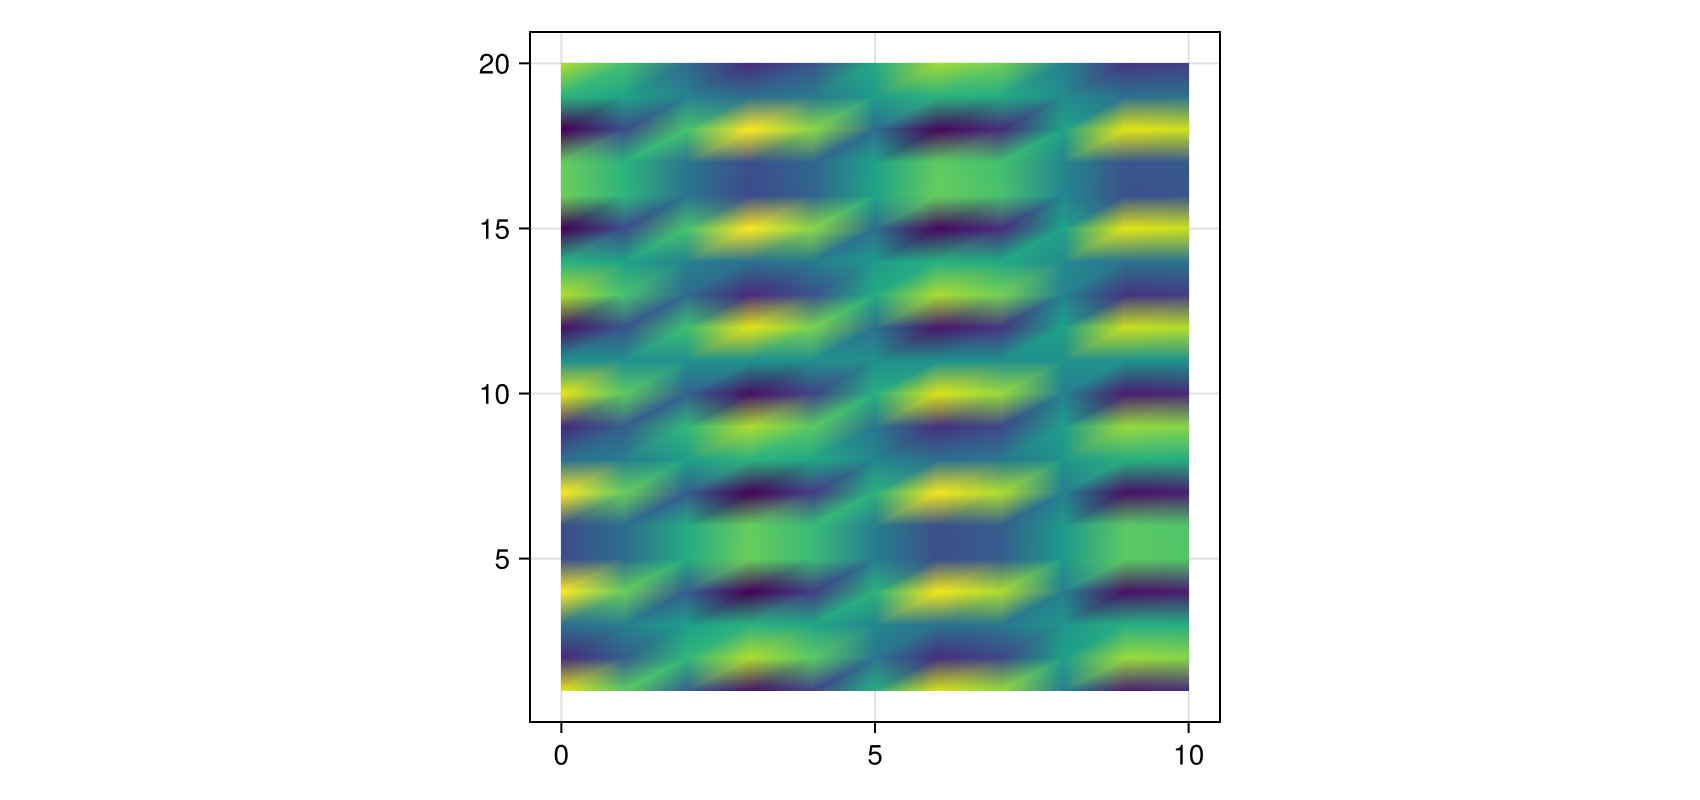

CairoMakie.Screen{IMAGE}


In [39]:
fig = Figure(size = (850, 400))
ax1 = Axis(fig[1,1], aspect=1)
surface!(xxx, yyy, fff, shading=NoShading, interpolate=false)
display(fig)